# Packages Installation

Before running the code blocks, the following block should be uncommented and run in order to install the packages required for this custom estimator. Through this ipython notebook, python 3.6 is used.

In [1]:
# !pip install -r requirements.txt --user

## Background
The task of reading an analog gauge requires visual inspection. For some industries, this can require a human operator to travel to the location of the gauge, read its current value (sometimes using binoculars) and log that value to enable the reading to be used elsewhere. This can be costly because of the need for having to dispatch a person to a remote location, incomplete because the data is only available after it is logged and slow due to the lag time between when the data is read and when it enters the system. Being able to read the gauge using computer vision provides the ability to integrate the gauge reading into an automated system will provide multiple advantages including:
* Reducing the need for a maintenance crew to travel to remote locations
* Providing near real-time, continuous access to the gauge levels
* The ability to monitor the gauge readings and automatically generate alerts

## Description
The Deep Gauge project is designed to provide support for reading an analog gauge using computer vision and machine learning. The objective is to be able to train the system to read the values of the gauge for use in commercial and industrial settings to minimize the need for manual inspection and intervention. One application of this capability is in the power industry, where many existing enclosures still utilize analog gauges that must be read by technicians with the data being logged for subsequent analysis. Through the use of a mounted camera, the gauge readings can be converted to a digital signal that can be automaticially and continuously monitored and logged for use within the organization. ￼


## Approach

Various approaches based on image processing using OpenCV and signal processing have been explored in industry. In this demo we explore a CNN based deep learning approach to read gauge dial readings using the images captured from edge devices such as phones or a Raspberry Pi. 

A Tensorflow custom estimator is used to train the CNN model on the Google Cloud Platform (GCP) ML Engine. The trained model is also deployed on GCP and employed to make the predictions accessible via a standard RESTful interface.

## Data Generation, Preprocessing and the Data pipeline

The block diagram below shows a process for generating a training set for a gauge dial for multiple dial positions {{KS: Provide a link to the code that performs this process.}} (<a href="https://github.com/oci-labs/deep-gauge/blob/master/2.%20Data%20Augmentation%20of%20synthetic%20gauges.ipynb">link to the code</a>). The needle and the background for the particular image is seperated using an image processing tool. The needle image separated from the gauge dial is then rotated for each of the required angles and added to the background to generate  candidate images for every label/class corresponding to gauge dial reading. To increase the dataset we augument the images using transformations like scaling, rotation, cropping etc. 

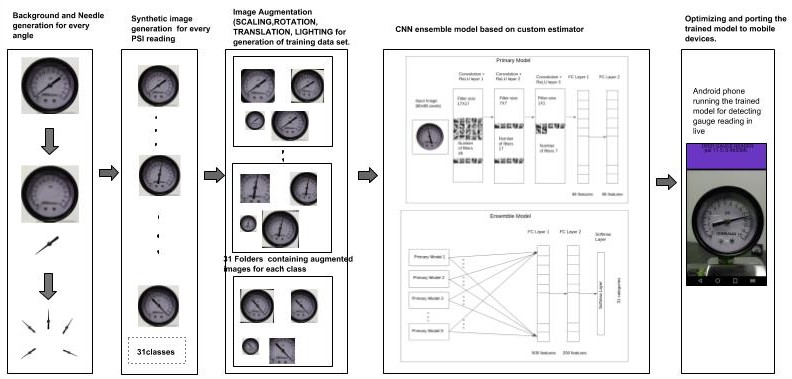

In [2]:
from IPython.display import Image
Image(filename='statics/diagram_1.jpg')

### Training and Validation Datasets Preparation

The image dataset is first split into "train" and "validation" datasets, and then the images size and color mode are adjusted (using the keras.preprocessing package) (<a href="https://github.com/oci-labs/DeepGauge-ML-Demo/blob/master/CustomEstimator/modules/primary_models_modules/train_modules/LoadImg.py">link to the code</a>). {{KS: Is this done manually or is there code to do this? Should be some code and we should link to it here.}} The following code block shows how the datasets can be obtained via LoadImg module.  {{KS: The following block gives an error "ModuleNotFoundError: No module named 'keras'" when I run it.}}

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from modules.primary_models_modules.train_modules import LoadImg
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


Before runing the following code block, the data folder needs to be copied in the CustomEstimator folder.

In [4]:
X_train, X_validation, y_train, y_validation, cls_indices = LoadImg.Dataset.prep_datasets(
    ver_ratio=0.2, container_path='data/ImageEveryUnit',
    final_img_width=79, final_img_height=79,
    color_mode="grayscale", random_state=1911)


The image pre-processing is complete.


## Data Exploration

### Train and Validation Datasets
There are 1315 images in the training dataset and 329 images in the validation dataset.  {{KS: I get the following error when I run the block below: "NameError: name 'X_train' is not defined"}} 

In [5]:
print('There are {} images in the train dataset.'.format(X_train.shape[0]))
print('There are {} images in the validation dataset.'.format(X_validation.shape[0]))
print('The images shape is {}'.format(X_train.shape[1:]))

There are 1315 images in the train dataset.
There are 329 images in the validation dataset.
The images shape is (79, 79, 3)


In this example, a width and height of 79 were chosen, so the images shape is (79, 79, 3). In the following code blocks, 12 images are randomly selected from train and validation datasets. The augmentation techniques applied on the images are as follows:
- Scaling
- Translation
- Rotation
- Adding Salt and Pepper noise

The set of images generated through image augmentation helps the model to generalize better for various conditions and to minimize overfitting (further explanation of the augmentation techniques and the code used here is provided in this <a href="https://github.com/oci-labs/deep-gauge/blob/master/2.%20Data%20Augmentation%20of%20synthetic%20gauges.ipynb">link</a>).

{{KS: Please provide a description of processing done on images. Noise was applied to the images apparently. Provide a description of what was done and the motivation. Also get the same error about X_train not being defined in the following.}}

#### Training Data Samples

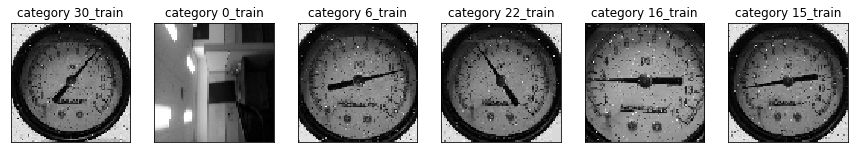

In [6]:
fig = plt.figure(figsize=(15,2.5))
imgs_num = np.random.choice(range(len(X_train)), 6)

for i, img_num in enumerate(imgs_num):
    ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[img_num, :, :, 0], cmap='gray')
    ax.set_title('category {}_train'.format(np.argmax(y_train[img_num])))


#### Validation Data Samples
{{KS: Iget the error "NameError: name 'X_validation' is not defined" in the block below"}}

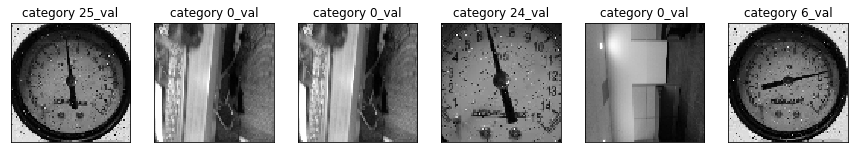

In [7]:
fig = plt.figure(figsize=(15,2.5))
imgs_num = np.random.choice(range(len(X_validation)), 6)

for i, img_num in enumerate(imgs_num):
    ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_validation[img_num, :, :, 0], cmap='gray')
    ax.set_title('category {}_val'.format(np.argmax(y_validation[img_num])))

## Ensembling

The objective of this work is to train multiple models (here, referred to as __primary models__) and eventually use them to construct an ensemble model (a two layer fully connected neural network) which can perform with higher validation accuracy than each individual primary models. To construct the ensemble model, first the primary models are trained and then the probabilities (i.e. the output of the last layer softmax activation functions) of all models are computed and stacked into an array (1D tensor) which will be the input of the ensembling Deep Neural Network (DNN). The ensemble DNN is a classifier that is to predict the same 31 categories. It is trained with the same training dataset and its performance is evaluated versus the same validation dataset as those used for the primary models.

### Primary Models



For each primary model, a Covolutional Neural Network (CNN) architechture is trained and used for predicting the gauge images categories. There are 30 categories that show the pressure level collected by the gauge with half of the pressure unit (here psi) increments and one NaN category (31 categories all together).

The CNN model consists of three CNN and two Fully Connected (FC) layers (the layers are defined in the NewLayers module, CustomEstimator/modules/primary_models_modules/train_modules/NewLayers.py, and the CNN architecture is structured in the NeuralNet module, CustomEstimator/modules/primary_models_modules/train_modules/NeuralNet.py). The activation function of all layers is Rectified Linear Unit (relu) except the last layer which is softmax. The following diagram shows the primary model architecture.

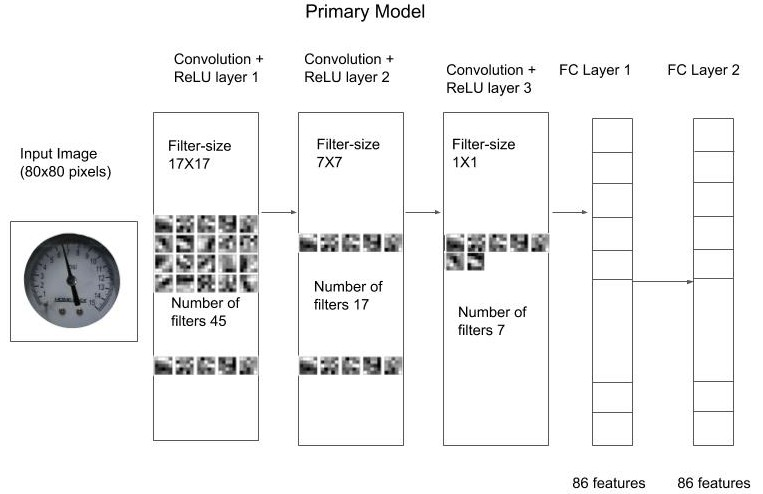

In [8]:
Image(filename='statics/diagram_2.jpg')

For training the primary models, the cross-entropy function (<a href="http://www.deeplearningbook.org/contents/ml.html">reference</a>) and Adam algorithm (<a href="https://arxiv.org/abs/1412.6980">reference</a>) {{KS: provide a reference}} are employed as the cost function and optimizer, respectively. The model performance is evaluated in each training iteration via the accuracy of the validation dataset and the model checkpoint is saved (in the modules/primary_models_modules/logs/models/main folder) whenever the accuracy is improved.

### Primary Models Training

For the primary models hyperparameter tuning, first a model was trained using images with the same width/height ratio as the original images (one is shown shown below){{KS: Insert sample image here}}. The hyperparameters of this model were manually tuned and the ones that resulted better performance (i.e. validation dataset accuracy) were used for the subsequent primary models.

{{KS: I get the following error from the block below: "ModuleNotFoundError: No module named 'tensorflow'"}}


Text(0.5,1,'category 22_train')

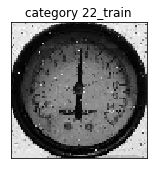

In [9]:
fig = plt.figure(figsize=(15,2.5))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax.imshow(X_train[4, :, :, 0], cmap='gray')
ax.set_title('category {}_train'.format(np.argmax(y_validation[2])))

In [10]:
from modules.primary_models_modules.train_modules import OptimizeAndLog

##
OptimizeAndLog.OptimizerLogger. \
    train_and_save_logs_three_CNN(filter_size1=17, num_filters1=45, strides_1=[1, 7, 7, 1],
                                  use_pooling_1=True, pooling_ksize_1=[1, 4, 4, 1], pooling_strides_1=[1, 4, 4, 1],
                                  ##
                                  filter_size2=7, num_filters2=17, strides_2=[1, 5, 5, 1],
                                  use_pooling_2=True, pooling_ksize_2=[1, 3, 3, 1], pooling_strides_2=[1, 3, 3, 1],
                                  ##
                                  filter_size3=1, num_filters3=7, strides_3=[1, 1, 1, 1],
                                  use_pooling_3=False, pooling_ksize_3=None, pooling_strides_3=None,
                                  ##
                                  fc_size=86,
                                  num_iterations=1,
                                  learning_rate=2e-4, momentum=None,
                                  X_train=X_train, y_train=y_train,
                                  X_test=X_validation, y_test=y_validation,
                                  models_log_path='./modules/primary_models_modules/logs/models/',
                                  cls_indices=cls_indices,
                                  keep_best_model = True,
                                  padding='SAME',
                                  device_name="/cpu:0")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

After 1 epochs train_acc is 0.0373 and test_acc is 0.0395

Time usage: 0:00:02


### Feature Engineering

The aspect ratio of the images was changed and for each aspect ratio a model was trained and its saved checkpoint was manually copy-pasted to the modules/primary_models_modules/logs/primary_models for the final ensemble model.

{{KS: I get the following error from the block below: "NameError: name 'LoadImg' is not defined".}}

{{KS: I get the following error from the block after that: "NameError: name 'X_train_2' is not defined"}}

In [11]:
X_train_2, X_validation_2, y_train_2, y_validation_2, _ = LoadImg.Dataset.prep_datasets(
    ver_ratio=0.2, container_path='data/ImageEveryUnit',
    final_img_width=160, final_img_height=80,
    color_mode="grayscale", random_state=1911)

The image pre-processing is complete.


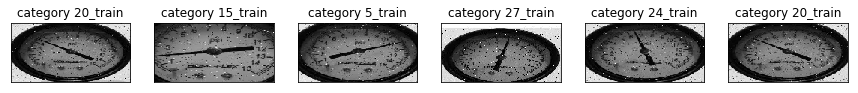

In [12]:
fig = plt.figure(figsize=(15,2.5))
imgs_num = np.random.choice(range(len(X_train_2)), 6)

for i, img_num in enumerate(imgs_num):
    ax = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train_2[img_num, :, :, 0], cmap='gray')
    ax.set_title('category {}_train'.format(np.argmax(y_train_2[img_num])))

Eight primary models were trained and their checkpoints are used for the ensemble model.

### Ensemble Model

Training the primary models, their checkpoints are used to construct the ensemble model in a tensorflow graph. The following diagram shows the architecture of the ensemble model.

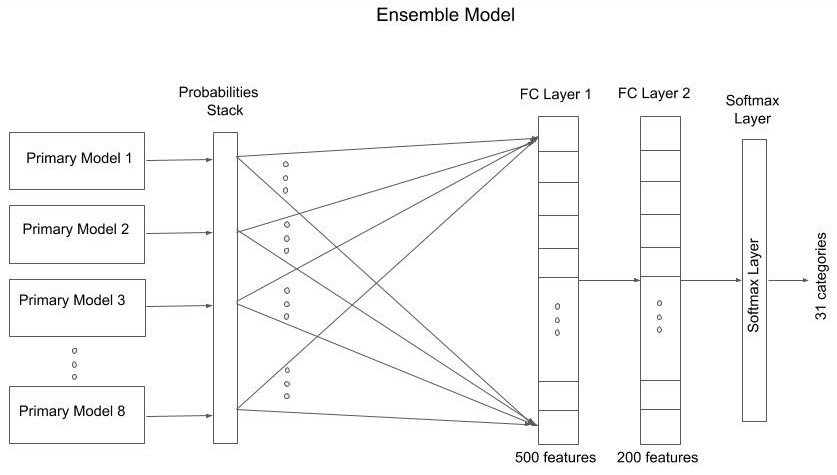

In [13]:
Image(filename='statics/diagram_3.jpg')

In this ensemble model, each primary model outputs the probabilities of 31 categories and the outputs of all the models are stacked up and fed into a two layer Deep Neural Network (DNN). The code for constructing the ensemble architecture can be found in this <a href="https://github.com/oci-labs/DeepGauge-ML-Demo/blob/master/CustomEstimator/modules/ensemble_modules/trainer_from_storage/trainer/model.py">link</a>.

## Custom Estimator

A custom estimator is used to train the ensemble model on GCP. To train the model, the model graph is first built and saved on a GCP bucket and then imported and used in a Python function that is employed as the model_fn of the estimator.

For this custom estimator, a serving input receiver function is used that accepts image(s) converted to base64. The following code block shows the serving input receiver function used here:

In [14]:
def serving_input_receiver_func():
    images_str = tf.placeholder(tf.string, shape=[None], name='export_input_image_bytes')
    def decode_and_resize(image_str_tensor):
        image = tf.image.decode_jpeg(image_str_tensor, channels=3)
        image = tf.expand_dims(image, 0)
        image = tf.image.resize_bilinear(image, [224, 224], align_corners=False)
        image = tf.squeeze(image, squeeze_dims=[0])
        return image
    images = tf.map_fn(decode_and_resize, images_str, dtype=tf.float32)
    return tf.estimator.export.ServingInputReceiver({'img': images}, {'bytes': images_str})

The tf.estimator.train_and_evaluate utility function is used to train, evaluate, and export the model. The trained models are exported to a GCP bucket, which later can be deployed on the GCP ML Engine.

## Hyper-parameters Tunning

The following block shows the contents of the yaml file used for hyper-parameters tunning: 

{{KS: I get the following error from the following block. Probably not intended to be executed in this notebook:
"SyntaxError: invalid syntax"}}

The yaml file is passed to the config argument when the training job is submitted on GCP, and the learning_rate and batch_size values are optimized through the hyperparamter-tunning job to get the highest validation accuracy.

The best value of 0.933 was achieved for the validation accuracy where the batch_size and learning_rate parameters were respectively 400 and 0.00086.

## Model Deployment

A model with the optimal hyper-parameters was trained and exported to a bucket. Then, the exported model was deployed on the GCP ML Engine to be employed for prediction{{KS: Provide some additional details on deployment of the model. Perhaps have a script that could be used to do the deployment.}}. In order to deploy the model, the following steps were done using gcloud shell commands:

To use the deployed model, a GCP cloud function is used where the image data, converted to base64, is passed to the deployed model and the prediction results are received.